In [1]:
import dgl
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd
import torch

Using backend: pytorch


In [2]:
pt_data = pd.read_excel('./CRC_TMAs_patient_annotations.xlsx')
cell_data = pd.read_csv('./CRC_master.csv')

In [3]:
LABEL = "label"
CENTROID = "centroid"
FEATURES = "feat"
def data_to_dgl_graph(pt_data, cell_data, k=5, thresh=50, mode="distance", normalize=False):
    labs, ids = np.unique(cell_data.loc[:,'ClusterName'].to_numpy(), return_inverse=True)
    cell_data['ClusterID'] = ids
    graphs = []
    patients = []
    targets = []
    for spot in cell_data["spots"].unique():
        subset = cell_data.loc[cell_data.loc[:,'spots'] == spot,:]
        features = subset.loc[:,'size':'Treg-PD-1+'].to_numpy() # TODO: This step depends on column order
        if normalize:
            features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
        centroids = subset.loc[:,'X':'Y'].to_numpy()
        annotation = subset.loc[:,'ClusterID'].to_numpy()
        num_nodes = features.shape[0]
        graph = dgl.DGLGraph()
        graph.add_nodes(num_nodes)
        graph.ndata[CENTROID] = torch.FloatTensor(centroids)
        graph.ndata[FEATURES] = torch.FloatTensor(features)
        if annotation is not None:
            graph.ndata[LABEL] = torch.FloatTensor(annotation.astype(float))
        adj = kneighbors_graph(
            centroids,
            k,
            mode=mode,
            include_self=False,
            metric="euclidean").toarray()
        if thresh is not None:
            adj[adj > thresh] = 0
        edge_list = np.nonzero(adj)
        graph.add_edges(list(edge_list[0]), list(edge_list[1]))
        graphs.append(graph)
        assert(len(subset['patients'].unique()) == 1)
        patients.append(subset['patients'].unique()[0])
    for pt in patients:
        cp = pt_data.loc[pt_data.loc[:,'Patient'] == pt,'Group'].values[0]
        assert(cp == 1 or cp == 2)
        t = 0 if cp == 1 else 1
        targets.append(t)
    return list(zip(graphs,targets)), labs, ids

In [4]:
import torch
from tqdm import trange
from histocartography.ml import CellGraphModel
import random
import copy
from torch.utils.data import DataLoader

from histocartography.interpretability import (
    GraphPruningExplainer,
    GraphGradCAMExplainer,
    GraphGradCAMPPExplainer,
    GraphLRPExplainer
)

def collate(batch):
    g = dgl.batch([example[0] for example in batch])
    l = torch.LongTensor([example[1] for example in batch])
    return g, l

def collate_graph(batch):
    return dgl.batch(batch)

def dataset_split(data, val_prop):
    if val_prop == 0:
        return data, data
    random.shuffle(data)
    train_data = data[:int(len(data)*val_prop)]
    val_data = data[int(len(data)*val_prop):]
    return train_data, val_data

#TODO: More sophisticated oversample
def oversample_positive(data, oversample_factor=2):
    negative = []
    positive = []
    for item in data:
        if item[1] == 0:
            negative.append(item)
        else:
            positive.append(item)
    positive = oversample_factor*positive
    return positive+negative

class CGModel():
    def __init__(self, gnn_params, classification_params, node_dim, num_classes=2, lr=10e-4, weight_decay=5e-4, num_epochs=50, batch_size=8):
        self.gnn_params = gnn_params
        self.classification_params = classification_params
        self.node_dim = node_dim
        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.cgm = CellGraphModel(gnn_params, classification_params, node_dim, num_classes=2)

    def train(self, data, val_prop=0, oversample_factor=1):
        optimizer = torch.optim.Adam(
            self.cgm.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        # define loss function
        loss_fn = torch.nn.CrossEntropyLoss()
        # training
        loss = 10e5
        val_accuracy = 0.
        train_dataloader = None
        val_dataloader = None
        loss_list = []
        val_accuracy_list = []
        train_data, val_data = dataset_split(data, val_prop)
        train_data = oversample_positive(train_data, oversample_factor=oversample_factor)
        train_dataloader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True, collate_fn=collate)
        val_dataloader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True, collate_fn=collate)
        with trange(self.num_epochs) as t:
            for _ in t:
                t.set_description('Loss={} | Val Accuracy={}'.format(loss, val_accuracy))
                self.cgm.train()
                for graphs, labels in train_dataloader:
                    logits = self.cgm(graphs)
                    loss = loss_fn(logits, labels)
                    loss_list.append(loss.item())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                self.cgm.eval()
                all_val_logits = []
                all_val_labels = []
                for graphs, labels in val_dataloader:
                    with torch.no_grad():
                        logits = self.cgm(graphs)
                    all_val_logits.append(logits)
                    all_val_labels.append(labels)
                all_val_logits = torch.cat(all_val_logits).cpu()
                all_val_labels = torch.cat(all_val_labels).cpu()
                with torch.no_grad():
                    _, predictions = torch.max(all_val_logits, dim=1)
                    correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
                    val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)
                    val_accuracy_list.append(val_accuracy)
        return loss_list, val_accuracy_list
    
    def infer(self, graphs):
        val_dataloader = DataLoader(graphs, batch_size=self.batch_size, collate_fn=collate_graph)
        with torch.no_grad():
            all_preds = []
            for graph_batch in val_dataloader:
                logits = self.cgm(graph_batch)
                _, predictions = torch.max(logits, dim=1)
                all_preds.append(predictions)
            all_preds = torch.cat(all_preds).cpu()
            return all_preds
    
    def test(self, data):
        val_dataloader = DataLoader(data, batch_size=self.batch_size, shuffle=True, collate_fn=collate)
        self.cgm.eval()
        all_val_logits = []
        all_val_labels = []
        for graphs, labels in val_dataloader:
            with torch.no_grad():
                logits = self.cgm(graphs)
            all_val_logits.append(logits)
            all_val_labels.append(labels)
        all_val_logits = torch.cat(all_val_logits).cpu()
        all_val_labels = torch.cat(all_val_labels).cpu()
        with torch.no_grad():
            _, predictions = torch.max(all_val_logits, dim=1)
            correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
            val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)
        return val_accuracy
    
    def save(self, model_path):
        #TODO: Save model and params to model path
        pass

    def load(self, model_path):
        #TODO: Load model cpt and params from model path
        pass

def get_model_score_dict(cgm_model, data, labs):
    grad_campp_explainer = GraphGradCAMPPExplainer(model=cgm_model.cgm)
    grad_cam_explainer = GraphGradCAMExplainer(model=cgm_model.cgm)
    graph_frames = []
    for e in data:
        graph = e[0]
        target = e[1]
        campp = grad_campp_explainer.process(graph)[0]
        cam = grad_cam_explainer.process(graph)[0]
        with torch.no_grad():
            c = copy.deepcopy(graph)
            logits = cgm_model.cgm(c)
            pred = torch.argmax(logits)
        l = graph.ndata['label'].numpy()
        pos = graph.ndata['centroid'].numpy()
        l = [labs[int(i)] for i in l]
        d = pd.DataFrame({'cell_type': l, 'score_campp': campp, 'score_cam': cam, 'X':pos[:,0],'Y':pos[:,1]})
        d.attrs['group'] = target+1
        d.attrs['pred'] = pred+1
        graph_frames.append(d)
    return graph_frames


        

In [5]:
gnn_params = {'readout_op': 'concat',
 'layer_type': 'gin_layer',
 'agg_type': 'mean',
 'output_dim': 16,
 'num_layers': 2,
 'readout_type': 'mean',
 'batch_norm': True,
 'act': 'relu'}
classification_params = {'hidden_dim': 16, 'num_layers': 2}

In [6]:
data, labs, ids = data_to_dgl_graph(pt_data, cell_data, mode='connectivity', normalize=True)

<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-features.mean(axis=0))/features.std(axis=0))
<ipython-input-3-5a7eae68304c>:14: RuntimeWarning: invalid value encountered in true_divide
  features = np.nan_to_num((features-f

In [8]:
model = CGModel(gnn_params=gnn_params, classification_params=classification_params, node_dim=74, num_epochs=50)

In [9]:
model.train(data)

Loss=0.3180655539035797 | Val Accuracy=1.0: 100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


([0.6725571751594543,
  0.6721739172935486,
  0.6757001876831055,
  0.6759265065193176,
  0.6688120365142822,
  0.6399719715118408,
  0.7252854108810425,
  0.6990319490432739,
  0.6934173703193665,
  0.7700895071029663,
  0.6576976776123047,
  0.7742931246757507,
  0.6671364307403564,
  0.7202672958374023,
  0.6868259906768799,
  0.6055718660354614,
  0.7320019006729126,
  0.6556752920150757,
  0.6962933540344238,
  0.6863499879837036,
  0.6597884893417358,
  0.6893924474716187,
  0.6639009118080139,
  0.6805341839790344,
  0.7016878128051758,
  0.6630699634552002,
  0.7230485081672668,
  0.7006175518035889,
  0.6327391862869263,
  0.6289977431297302,
  0.6520423889160156,
  0.6720759868621826,
  0.6196160316467285,
  0.6421907544136047,
  0.6418025493621826,
  0.6482856869697571,
  0.6302032470703125,
  0.6029061675071716,
  0.6406169533729553,
  0.6744455695152283,
  0.6809970140457153,
  0.6790619492530823,
  0.5950627326965332,
  0.581565260887146,
  0.7347975969314575,
  0.7723407

In [10]:
res = get_model_score_dict(model, data, labs)

/Users/raja/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:1000: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "


In [11]:
len(res)

140

In [12]:
import pickle

In [13]:
with open("importance_scores_group_prediction.pkl", 'wb') as f:
    pickle.dump(res, f)

In [15]:
scl = res[0]

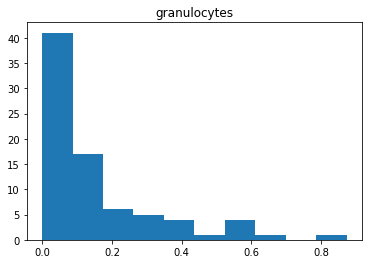

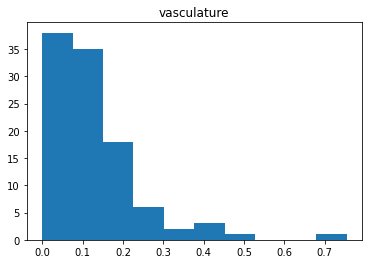

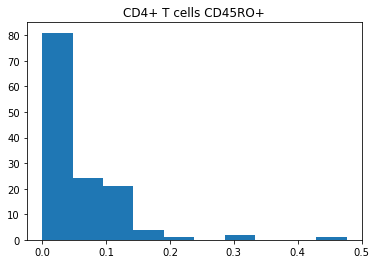

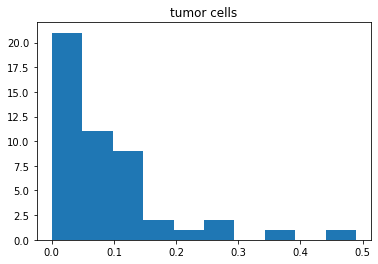

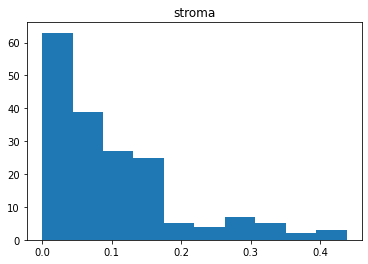

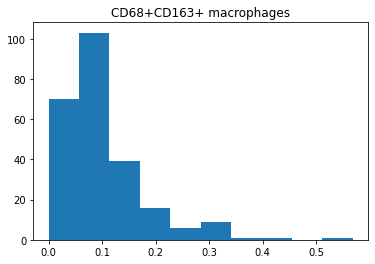

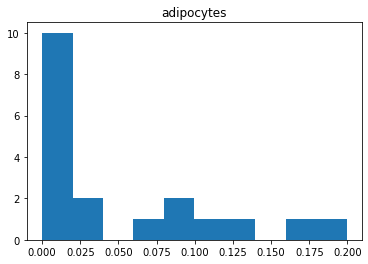

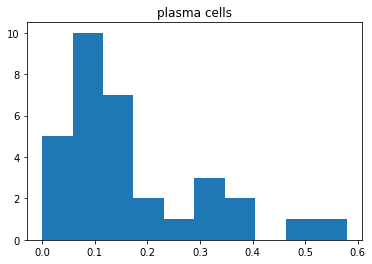

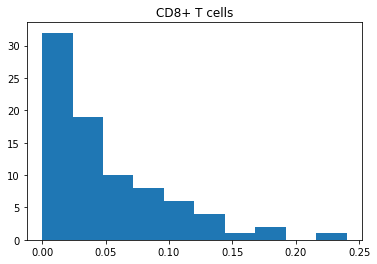

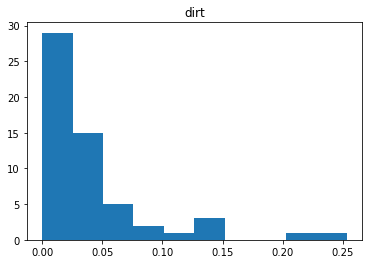

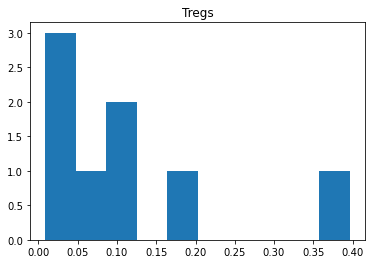

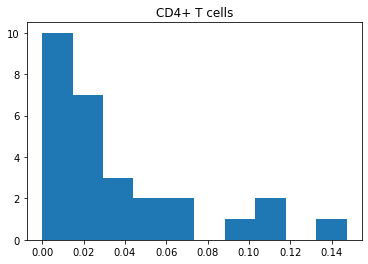

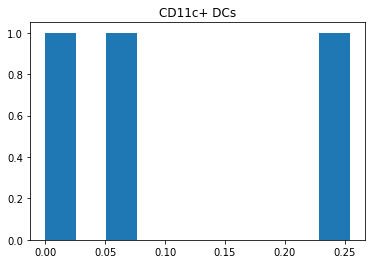

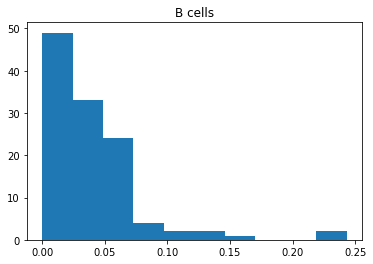

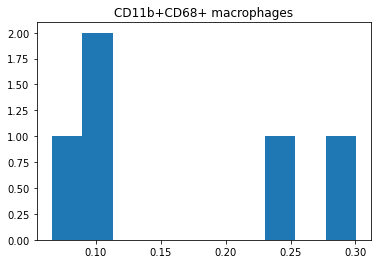

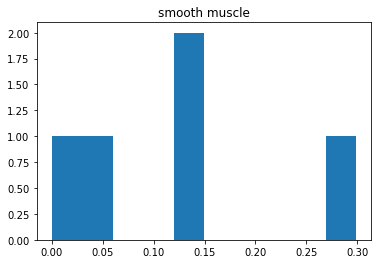

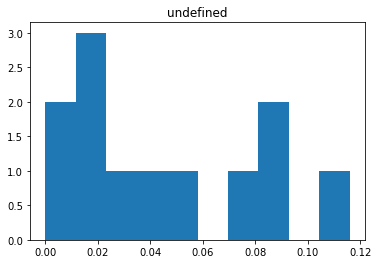

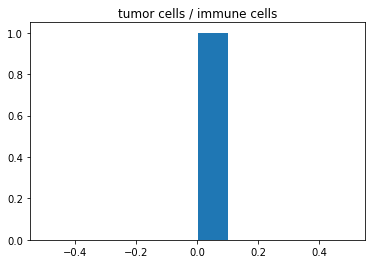

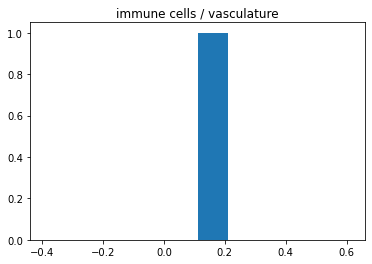

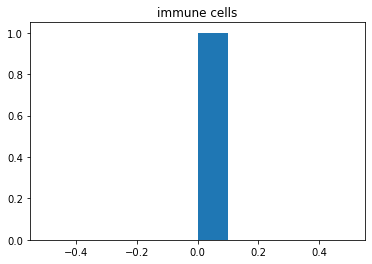

In [16]:
import matplotlib.pyplot as plt
for ct in scl.cell_type.unique():
    plt.hist(scl[scl['cell_type'] == ct].score_campp)
    plt.title(ct)
    plt.show()